In [282]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [283]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [284]:
print(device)

cuda


In [285]:
from google.colab import drive
drive.mount('/content/test')


Drive already mounted at /content/test; to attempt to forcibly remount, call drive.mount("/content/test", force_remount=True).


In [286]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [287]:
batch_size = 8
num_classes = 3
learning_rate = 0.001
num_epochs = 10

In [288]:
#Path for training and testing directory
train_path='/content/test/MyDrive/train'
test_path='/content/test/MyDrive/test'
validation_path = '/content/test/MyDrive/validation'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=batch_size, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=batch_size, shuffle=True
)

validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=8, shuffle=False
)


In [289]:
test_loader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [290]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [291]:
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [307]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out
            

In [304]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = LeNet5(num_classes=3).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [294]:
import numpy as np
epochs = 50
min_valid_loss = np.inf
val_losses = []
train_losses = []
for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
  

    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validation_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
        
 

    train_losses.append((train_loss / len(train_loader)))
    val_losses.append((valid_loss / len(validation_loader)))


    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')



 

Epoch 1 		 Training Loss: 1.00814018708009 		 Validation Loss: 0.27923205319572897
Validation Loss Decreased(inf--->4.746945) 	 Saving The Model
Epoch 2 		 Training Loss: 0.8162218531736961 		 Validation Loss: 0.12323276961550993
Validation Loss Decreased(4.746945--->2.094957) 	 Saving The Model
Epoch 3 		 Training Loss: 0.7286140100314067 		 Validation Loss: 0.13519429985214682
Epoch 4 		 Training Loss: 0.6589240285066458 		 Validation Loss: 0.08980825543403625
Validation Loss Decreased(2.094957--->1.526740) 	 Saving The Model
Epoch 5 		 Training Loss: 0.602337158872531 		 Validation Loss: 0.1524283254847807
Epoch 6 		 Training Loss: 0.5860052640621479 		 Validation Loss: 0.08216340752208934
Validation Loss Decreased(1.526740--->1.396778) 	 Saving The Model
Epoch 7 		 Training Loss: 0.539998748812538 		 Validation Loss: 0.036843603148179895
Validation Loss Decreased(1.396778--->0.626341) 	 Saving The Model
Epoch 8 		 Training Loss: 0.5260341322192779 		 Validation Loss: 0.060640060726

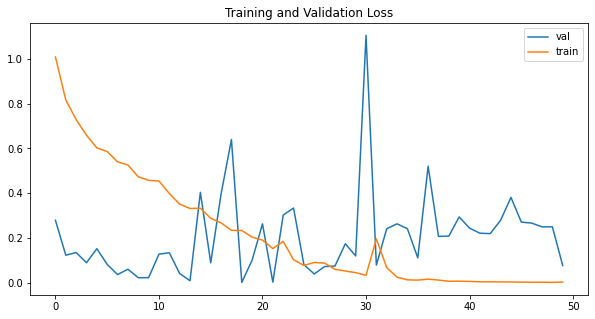

[0.27923205319572897, 0.12323276961550993, 0.13519429985214682, 0.08980825543403625, 0.1524283254847807, 0.08216340752208934, 0.036843603148179895, 0.060640060726334065, 0.022959941450287315, 0.023011999095187467, 0.12817661551868215, 0.13405795483028188, 0.04152844495633069, 0.009399628376259524, 0.40400974890765023, 0.08935693432303037, 0.3964657643262078, 0.6398959019604851, 0.001697864876512219, 0.10164151296896093, 0.26325029485365925, 0.0030903822249349427, 0.30235592056723204, 0.333861603456385, 0.08134653463083155, 0.03947797943564022, 0.07268998991040622, 0.07482607575023875, 0.17444580793380737, 0.12008367215885836, 1.1047099618350757, 0.0790057287496679, 0.24155481773264267, 0.26338117964127483, 0.24142270579057581, 0.11129908701952766, 0.5203749853021958, 0.20704672617070816, 0.20868439884746776, 0.29412045198328357, 0.24414262350867777, 0.22149824044283697, 0.21963789182550766, 0.27901099008672375, 0.38148483809302836, 0.27108946267296286, 0.26661637951346007, 0.2498411606

In [295]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.legend()
plt.show()


print(val_losses)


In [296]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [297]:
print(train_count,test_count)

1034 128


In [320]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = LeNet5(num_classes=3).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [321]:
from sklearn.metrics import f1_score

import numpy as np
from tqdm import tqdm
!pip install torchmetrics
import torch 
from torchmetrics import Precision


total_step = len(train_loader)
for epoch in range(14):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 15 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                       
y_true = []
y_pred = []

for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())
f1_score(y_true, y_pred, average='macro')
print(f1_score(y_true, y_pred, average='macro'))





with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Epoch [1/10], Step [15/130], Loss: 1.0808
Epoch [1/10], Step [30/130], Loss: 0.8960
Epoch [1/10], Step [45/130], Loss: 0.7871
Epoch [1/10], Step [60/130], Loss: 0.7912
Epoch [1/10], Step [75/130], Loss: 0.8385
Epoch [1/10], Step [90/130], Loss: 1.0665
Epoch [1/10], Step [105/130], Loss: 0.7640
Epoch [1/10], Step [120/130], Loss: 1.1234
Epoch [2/10], Step [15/130], Loss: 0.4525
Epoch [2/10], Step [30/130], Loss: 0.9269
Epoch [2/10], Step [45/130], Loss: 0.9504
Epoch [2/10], Step [60/130], Loss: 0.8160
Epoch [2/10], Step [75/130], Loss: 0.6877
Epoch [2/10], Step [90/130], Loss: 0.7133
Epoch [2/10], Step [105/130], Loss: 0.9726
Epoch [2/10], Step [120/130], Loss: 0.6629
Epoch [3/10], Step [15/130], Loss: 0.8124
Epoch [3/10], Step [30/130], Loss: 0.7354
Epoch [3/10], Step [45/130], Loss: 0.5126
Epoch [3/10], Step [60/130], Loss: 0.6889
Epoch [3/10], Step [75/130], Loss: 0.4872
Epoch [3/10], S

100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


0.8060161654094768
Accuracy of the network on the 10000 test images: 80.46875 %


In [322]:
import sklearn.metrics

print("f1 score",f1_score(y_true, y_pred, average='macro'))
print("f1 score",f1_score(y_true, y_pred, average='micro'))
print("accuracy_score",sklearn.metrics.accuracy_score(y_true, y_pred))
print("balanced accuracy_score",sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
print("precision_score",sklearn.metrics.precision_score(y_true, y_pred, average='macro'))
print("rECALL micro",sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print("rECALL macro",sklearn.metrics.recall_score(y_true, y_pred, average='macro'))

f1 score 0.8060161654094768
f1 score 0.8046875
accuracy_score 0.8046875
balanced accuracy_score 0.8047249907715024
precision_score 0.8119752405466691
rECALL micro 0.8046875
rECALL macro 0.8047249907715024


100%|██████████| 16/16 [00:01<00:00, 15.72it/s]


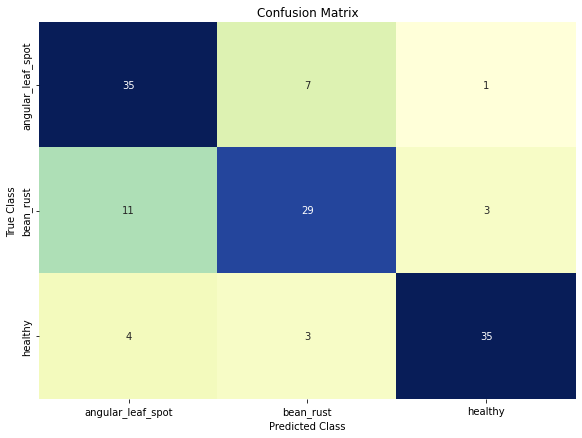

In [323]:
import seaborn as sns
from tqdm import tqdm
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
 
for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())


cf_matrix = confusion_matrix(y_true, y_pred)

class_names = ('angular_leaf_spot', 'bean_rust', 'healthy')
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)


plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()